In [194]:
from pathlib import Path
from typing import Iterable, Union

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import trapezoid
import seaborn as sns

sns.set_theme(style="white")

ROGI_KEY = "rogi"
CSV_DIR = Path("./results/raw/rogi/tdc")
FEATURES = ["VAE", "GIN", "ChemBERTa", "ChemGPT"]
FEATURES_TO_COLOR = {
    f.upper(): c for f, c in zip(FEATURES, sns.color_palette("deep", len(FEATURES)))
}

In [2]:
def disable_gridlines(ax: plt.Axes, axis: str, vals: Union[float, Iterable[float]]):
    if isinstance(vals, float):
        vals = [vals]

    vals = set(vals)
    gridlines = ax.get_xgridlines() if axis == "x" else ax.get_ygridlines()

    for line in gridlines:
        val = line.get_xdata()[0] if axis == "x" else line.get_ydata()[0]
        if val in vals:
            line.set_visible(False)
    
    return ax


def rogi_string(x: str):
    return rf"$\mathrm{{ROGI}}_{{\mathrm{{{x}}}}}$"

In [3]:
dfs = list(map(pd.read_csv, CSV_DIR.iterdir()))
df = pd.concat(dfs, ignore_index=True)\
    .groupby(["features", "dataset_and_task"])\
    .agg({"n_valid": "mean", "rogi": ["mean", "std", "count"]})\
    .sort_index()

df.head(15)

n_valid      rogi                
                                           mean      mean       std count
features  dataset_and_task                                               
chemberta AMLODIPINE_MPO                10000.0  0.375792  0.000000     5
          ARIPIPRAZOLE_SIMILARITY       10000.0  0.224105  0.000000     5
          CACO2_WANG                      910.0  0.286850  0.000000     5
          CELECOXIB_REDISCOVERY         10000.0  0.244493  0.000000     5
          CLEARANCE_HEPATOCYTE_AZ        1213.0  0.569957  0.000000     5
          CLEARANCE_MICROSOME_AZ         1102.0  0.501762  0.000000     5
          FEXOFENADINE_MPO              10000.0  0.502029  0.000000     5
          HALF_LIFE_OBACH                 667.0  0.110947  0.000000     5
          HERG_CENTRAL/hERG_at_10uM     10000.0  0.151121  0.060735     5
          HERG_CENTRAL/hERG_at_1uM      10000.0  0.101376  0.033180     5
          HERG_CENTRAL/hERG_inhib       10000.0  0.370091  0.004480     5
          HYDRATIONFREEENERGY_FREESOLV    642.0  0.201576  0.000000     5
          LD50_ZHU                       7385.0  0.150139  0.000000     5
          LIPOPHILICITY_ASTRAZENECA      4200.0  0.341132  0.000000     5
          LOGP                          10000.0  0.099349  0.000000     5

In [11]:
def parity_plot(
    ax: plt.Axes, df: pd.DataFrame, x_key: str, y_key: str, threshold: float = 0.1
):
    BUFFER = 0.03

    x = df.loc[x_key.lower()][ROGI_KEY]['mean'].values
    y = df.loc[y_key.lower()][ROGI_KEY]['mean'].values
    s = df.loc[x_key.lower()]["n_valid"]['mean'].values / 1e2
    z = (y - x) / x

    ax.scatter(x, y, s, z, vmin=-1, vmax=1, cmap="coolwarm", edgecolors='k', lw=1.3)

    ax.plot([[0, 0], [1, 1]], '--', c='grey', dashes=(4, 2.5), zorder=-1)

    # s = f"{rogi_string(y_key)} > {rogi_string(x_key)}"
    # N = (z > threshold).sum()
    # s = rf"$\Delta_\% \geq {threshold}$ : {N}/{len(z)}"
    # s = rf"$\frac{{y-x}}{{x}} \geq {threshold}$ : {N}/{len(z)}"
    # ax.text(
    #     0 + BUFFER, 1 - BUFFER, s, fontsize=12,
    #     transform=ax.transAxes, ha="left", va="top"
    # )
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(axis="both", ls="--")

    ax.set_ylabel(rogi_string(y_key))

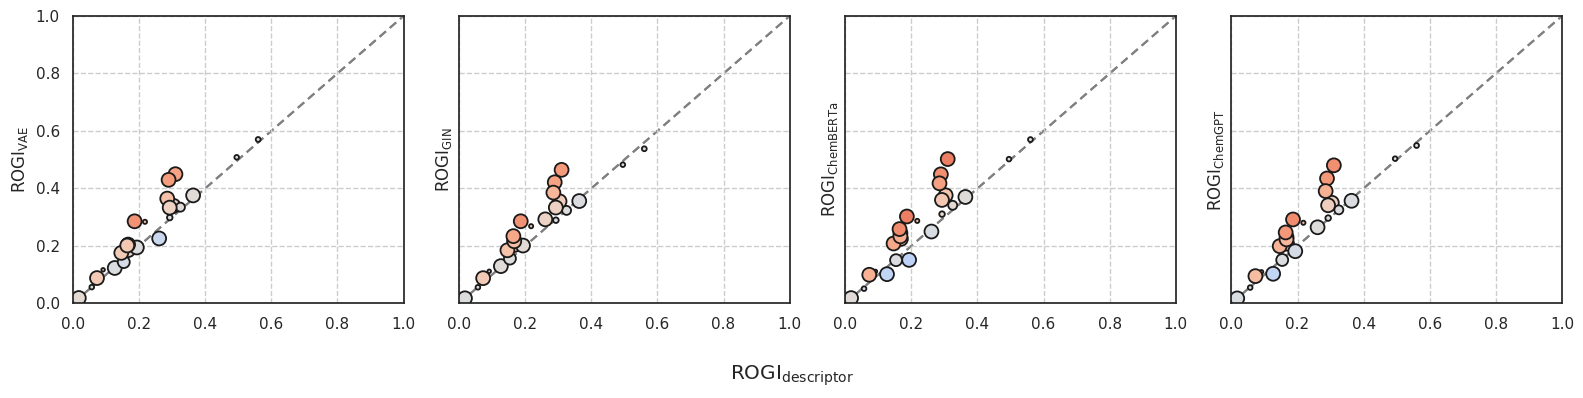

In [12]:
desc_key = "descriptor"
features = ["VAE", "GIN", "ChemBERTa", "ChemGPT"]
N = len(features)
fig, axs = plt.subplots(1, N, figsize=(4 * N, 4), sharex=True, sharey=True)

for ax, feature in zip(axs, features):
    parity_plot(ax, df, desc_key, feature, 0.10)

fig.supxlabel(rogi_string(desc_key))
fig.tight_layout()

In [4]:
fig.savefig(f"./results/figures/{'-'.join(Y_KEYS)}.pdf", bbox_inches="tight")

In [14]:
def boxplot(
    ax: plt.Axes,
    df: pd.DataFrame,
    desc_key: str,
    features: list[str],
    threshold: float = 0.1,
    jitter: float = 0.05,
    add_counts: bool = False
):
    LINE_WIDTH = 1.5
    BUFFER = 3

    x = df.loc[desc_key.lower()][ROGI_KEY]['mean'].values
    ys = [df.loc[f.lower()][ROGI_KEY]['mean'].values for f in features]
    Z = np.array(ys) / x - 1
    Z *= 100
    
    props = dict(
        boxprops=dict(fc="None", lw=LINE_WIDTH),
        whiskerprops=dict(lw=LINE_WIDTH),
        capprops=dict(lw=LINE_WIDTH),
        meanprops=dict(marker='^', mfc='w', mec='k'),
        medianprops=dict(ls='--', c='k'),
    )

    _ = ax.boxplot(
        Z.T,
        vert=False,
        labels=features,
        widths=0.5,
        showmeans=True,
        patch_artist=True,
        **props
    )

    ax.grid(which="both", axis="x", ls="--", dashes=(4, 4))
    ax.axvline(0, ls="--", color="r", dashes=(5, 4))

    for j in range(len(Z)):
        z = Z[j]
        y = (j + 1) * np.ones_like(z) + np.random.normal(0, jitter, z.shape)
        c = FEATURES_TO_COLOR[features[j].upper()]
        ax.scatter(z, y, color=c, marker='o', edgecolors='k', lw=1.3, zorder=20)

        if add_counts:
            s = rf"$f\geq{threshold:0.0%}$% = {(z > threshold).sum()}/{len(z)}"
            ax.text(
                ax.get_xlim()[1] + BUFFER, j+1, s, fontsize=10,
                ha="left", va="center"
            )

    ax.set_xlabel(f"Relative difference betweeen {rogi_string('*')} and {rogi_string('desc')} (%)")

    return ax

<AxesSubplot: xlabel='Relative difference betweeen $\\mathrm{ROGI}_{\\mathrm{*}}$ and $\\mathrm{ROGI}_{\\mathrm{desc}}$ (%)'>

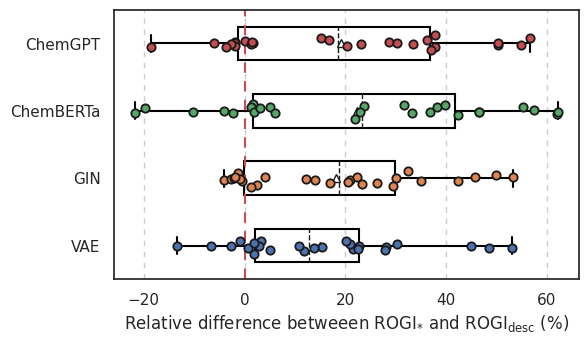

In [15]:
features = ["VAE", "GIN", "ChemBERTa", "ChemGPT"]
add_counts = False
fig, ax = plt.subplots(1, 1, figsize=(6 + add_counts, len(features) * 0.875))

boxplot(ax, df, "descriptor", features, 0.1)

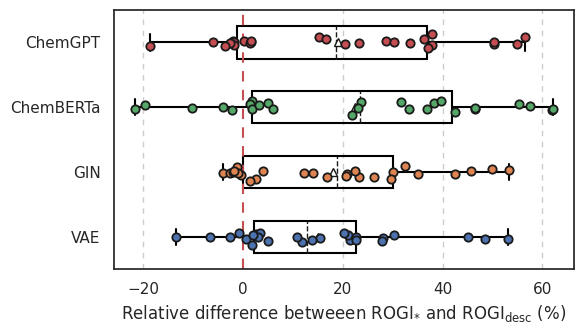

In [16]:
disable_gridlines(ax, "x", [0])
fig.tight_layout()
fig

In [130]:
fig.savefig("./results/figures/scatter-boxplot.pdf", bbox_inches="tight")

In [73]:
JSON_DIR = Path("./results/raw/cg/extremes/")

jsons = JSON_DIR.iterdir()
dfs = list(map(pd.read_json, jsons))
cg_df = pd.concat(dfs, ignore_index=True).set_index(["dataset_and_task", "features"]).sort_index()
cg_df

n_valid  \
dataset_and_task        features              
CLEARANCE_HEPATOCYTE_AZ chemberta      1213   
                        chemgpt        1213   
                        descriptor     1213   
                        gin            1213   
                        vae            1213   
VALSARTAN_SMARTS        chemberta     10000   
                        chemgpt       10000   
                        descriptor    10000   
                        gin           10000   
                        vae           10000   

                                                                           thresholds  \
dataset_and_task        features                                                        
CLEARANCE_HEPATOCYTE_AZ chemberta   [0.0, 0.0, 0.0103679765, 0.020495238500000002,...   
                        chemgpt     [0.0, 0.0, 0.0100518317, 0.0202371021, 0.03073...   
                        descriptor  [0.0, 0.0, 0.0100729401, 0.0202109427, 0.03028...   
                        gin         [0.0, 1.06e-08, 0.0132596056, 0.0234889055, 0....   
                        vae         [0.0, 0.0209435676, 0.0309853447, 0.0410294502...   
VALSARTAN_SMARTS        chemberta   [0.0, 0.0, 0.0106580851, 0.0207770258, 0.03079...   
                        chemgpt     [0.0, 0.0, 0.016234747600000002, 0.0327723081,...   
                        descriptor  [0.0, 0.0, 0.0106091976, 0.0206102781, 0.03062...   
                        gin         [0.0, 0.0026411244, 0.0153331473, 0.0308955916...   
                        vae         [0.0, 0.0188853082, 0.028886220900000002, 0.03...   

                                                                                  sds  
dataset_and_task        features                                                       
CLEARANCE_HEPATOCYTE_AZ chemberta   [0.677915252, 0.6362113443, 0.6318523113, 0.62...  
                        chemgpt     [0.677915252, 0.6362959799, 0.6361384943, 0.63...  
                        descriptor  [0.677915252, 0.6317526745, 0.6295295067000001...  
                        gin         [0.677915252, 0.6779141175000001, 0.6362961095...  
                        vae         [0.677915252, 0.6778845417, 0.6534322381000001...  
VALSARTAN_SMARTS        chemberta   [0.019999, 0.019999, 0.019999, 0.019999, 0.019...  
                        chemgpt     [0.019999, 0.019999, 0.019999, 0.019999, 0.019...  
                        descriptor  [0.019999, 0.019999, 0.019999, 0.019999, 0.019...  
                        gin         [0.019999, 0.019999, 0.019999, 0.019999, 0.019...  
                        vae         [0.019999, 0.019999, 0.019999, 0.0070682388, 0...

In [222]:
def dispersion_plot(ax: plt.Axes, thresholds, sds, title = None, y_label = None):
    BUFFER = 0.03

    y = sds[0] - sds
    ax.plot(thresholds, y, '-', mec='k', lw=2, alpha=0.9)
    ax.fill_between(thresholds, 0, y, alpha=0.3)

    rogi = sds[0] - trapezoid(sds, thresholds)
    bbox = dict(boxstyle='round', facecolor='white', alpha=0.7)
    s = f"ROGI = {rogi:0.2f}"
    ax.text(
        0 + BUFFER, 1 - BUFFER, s,
        ha="left", va="top", fontsize=10, transform=ax.transAxes, bbox=bbox
    )
    
    ax2 = ax.twinx()
    ax2.set_title(title, fontsize=12)
    ax2.set_ylabel(y_label, fontsize=10, labelpad=6, rotation=-90)
    ax2.yaxis.set_ticks([])#('none')

    ax.set_xlim(0, 1)
    ax.set_ylim(0)
    ax.yaxis.set_tick_params(which="both", direction="in", pad=6)
    

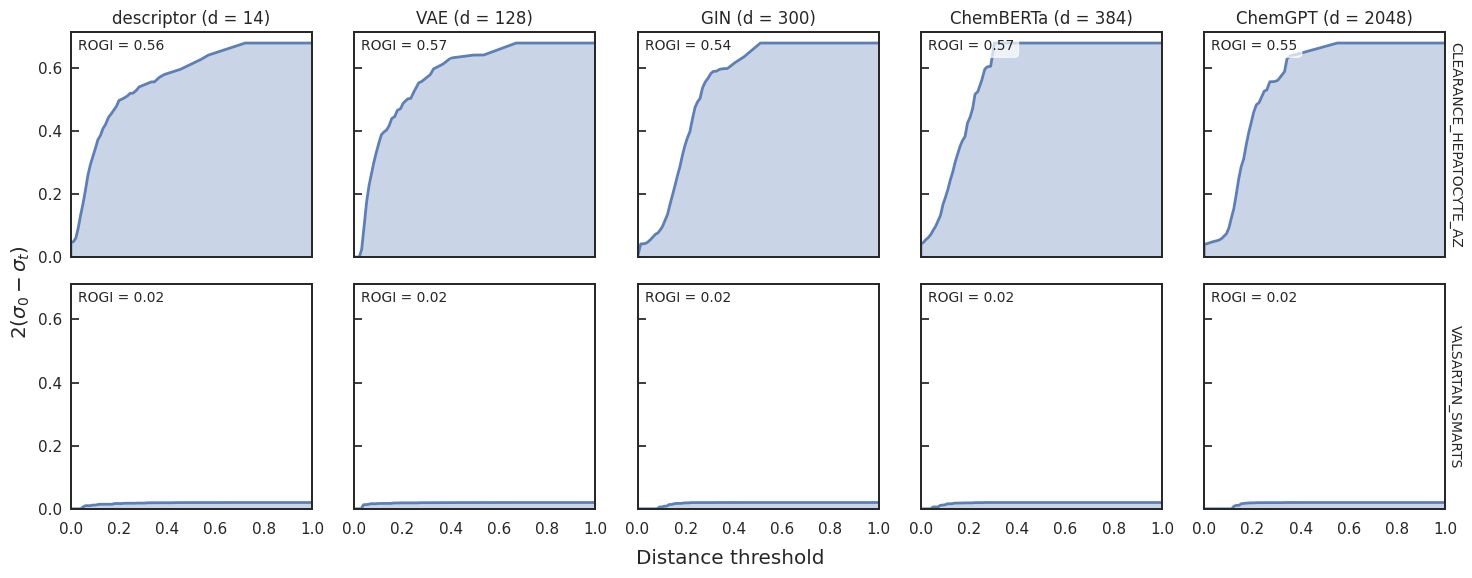

In [223]:
fig, axs = plt.subplots(*cg_df.index.levshape, figsize=(15, 6), sharex=True, sharey=True)

features = ["descriptor", "VAE", "GIN", "ChemBERTa", "ChemGPT"]
dims = [14, 128, 300, 384, 2048]

for i, dset in enumerate(cg_df.index.get_level_values("dataset_and_task").unique()):
    for j, feature in enumerate(features):
        s = cg_df.loc[dset, feature.lower()]

        title = f"{feature} (d = {dims[j]})" if i == 0 else None
        y_label = dset if j == len(features) - 1 else None
        dispersion_plot(axs[i, j], s.thresholds, np.array(s.sds), title, y_label)

fig.subplots_adjust(wspace=1)
fig.supxlabel("Distance threshold", y=0.04)
fig.supylabel(r"$2(\sigma_0 - \sigma_t)$")
fig.tight_layout()

In [172]:
fig.savefig("./results/figures/thresh-vs-sds.pdf", bbox_inches="tight")